* what is a service?
  - gtfs definition
  - defines when a trip is active (e.g. "service schedule" is a better word?)
  - calendar dates: "some set of trips apply to this day"
* how many schedules active in a specific day?
* how many routes have trips scheduled in a specific day?
* how many trips scheduled in a specific day?
* how many stops scheduled?
  - stops vs stop times?

In [1]:
# initial setup

%run 0_data_model.ipynb

pk_str = ["calitp_itp_id", "calitp_url_number"]
pk_col = (_.calitp_itp_id, _.calitp_url_number)

In [2]:
tbl_schedule_daily

,calitp_itp_id,calitp_url_number,service_id,service_cal_start_date,service_cal_end_date,calitp_extracted_at,service_indicator,service_date,service_inclusion,service_exclusion,is_in_service
0,256,0,Sunday,2010-12-31,2020-12-31,2021-04-16,0,2019-06-17,None,None,False
1,256,0,Sunday,2010-12-31,2020-12-31,2021-04-16,0,2014-08-25,None,None,False
2,256,0,Sunday,2010-12-31,2020-12-31,2021-04-16,0,2011-12-05,None,None,False
3,256,0,Saturday,2010-12-31,2020-12-31,2021-04-16,0,2012-06-18,None,None,False
4,256,0,Saturday,2010-12-31,2020-12-31,2021-04-16,0,2013-02-11,None,None,False


In [3]:
from plotnine import *
import datetime

DATE_START = str(datetime.date.today() - datetime.timedelta(weeks = 2))
DATE_END = str(datetime.date.today())

# Daily schedules

## Total counts and date ranges

In [4]:
(
    tbl_schedule_daily
    >> filter(_.is_in_service)
    >> summarize(
        ttl_schedule_days=n(_),
        ttl_unique_service_ids = _.service_id.nunique(),
        min_date=_.service_date.min(),
        max_date=_.service_date.max(),
        ttl_inclusions=_.service_inclusion.count(),
        ttl_exclusions=_.service_exclusion.count(),
    )
    >> collect()
)

,ttl_schedule_days,ttl_unique_service_ids,min_date,max_date,ttl_inclusions,ttl_exclusions
0,469094,1038,2010-12-31,2050-01-01,6090,0


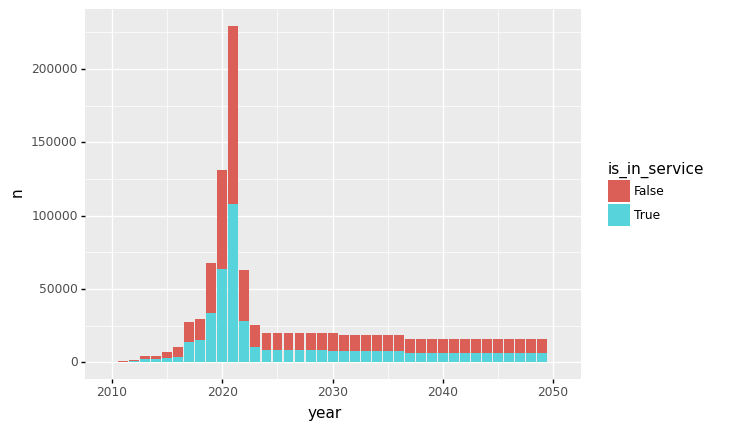

<ggplot: (-9223372036554963305)>

In [5]:
(
    tbl_schedule_daily
    >> count(year=_.service_date.dt.year, is_in_service=_.is_in_service)
    >> collect()
    >> ggplot(aes("year", "n", fill="is_in_service")) + geom_col()
)

## How many daily schedules are active for the past week?

In [6]:
(
    tbl_schedule_daily
    >> filter(_.is_in_service, _.service_date.between(DATE_START, DATE_END))
    >> summarize(
        ttl_schedule_days=n(_),
        ttl_unique_service_ids=_.service_id.nunique(),
        min_date=_.service_date.min(),
        max_date=_.service_date.max(),
        ttl_inclusions=_.service_inclusion.count(),
        ttl_exclusions=_.service_exclusion.count(),
    )
    >> collect()
)

,ttl_schedule_days,ttl_unique_service_ids,min_date,max_date,ttl_inclusions,ttl_exclusions
0,7059,830,2021-05-03,2021-05-17,794,0


## How does calendar_dates affect daily schedules?

In [7]:
(
    tbl_schedule_daily
    >> count(
        _.service_indicator, _.service_inclusion, _.service_exclusion, _.is_in_service
    )
    >> collect()
    >> arrange(_.service_indicator, _.service_inclusion, _.service_exclusion)
)

,service_indicator,service_inclusion,service_exclusion,is_in_service,n
5,0,True,None,True,452
6,0,None,True,False,107
0,0,None,None,False,585847
7,1,True,None,True,3
3,1,None,True,False,2350
1,1,None,None,True,463004
2,None,True,None,True,5635
4,None,None,True,False,456


In [8]:
(
    tbl_schedule_daily
    >> summarize(
        ttl_inclusion=_.service_inclusion.count(),
        ttl_exclusion=_.service_exclusion.count(),
    )
)

,ttl_inclusion,ttl_exclusion
0,6090,2913


## Which schedules use only `calendar_dates.txt`?

In [9]:
tbl_schedule_daily >> filter(_.service_indicator.isna()) >> head(1)

,calitp_itp_id,calitp_url_number,service_id,service_cal_start_date,service_cal_end_date,calitp_extracted_at,service_indicator,service_date,service_inclusion,service_exclusion,is_in_service
0,1,4,FEB21-Weekday-72-FEB21-1111100-,None,None,None,None,2021-05-27,True,None,True


In [10]:
exception_schedules = (
    tbl_schedule_daily
    >> group_by(_.calitp_itp_id, _.calitp_url_number, _.service_id)
    >> filter(_.service_indicator.isna().all())
    >> ungroup()
)

exception_counts = (
    exception_schedules
    >> count(_.calitp_itp_id, _.calitp_url_number, _.service_id)
    >> arrange(-_.n)
)

df_exception_counts = exception_counts >> collect()
df_exception_counts

,calitp_itp_id,calitp_url_number,service_id,n
0,278,0,73346-1111111-0,126
1,278,0,72987-1111100-0,90
2,278,0,72952-1111100-0,88
3,278,0,72965-1111100-0,88
4,278,0,72954-1111100-0,88
...,...,...,...,...
218,278,0,72982-0000010-0,1
219,343,0,c_21375_b_29794_d_64,1
220,48,0,108699a6-0536-4926-bab1-56d4547e77c9,1
221,278,0,72976-0000001-0,1


### Do they occur on specific days?

It looks like there are more weekday entries, but seem fairly evenly spread out.

In [11]:
exception_dates = (
    exception_schedules
    >> left_join(_, tbl.views_dim_date(), {"service_date": "full_date"})    
    >> mutate(is_weekend = _.day_name.isin(["Saturday", "Sunday"]))
)

(exception_dates
        >> count(_.day_name) >> collect()
#     >> collect()
#     >> ggplot(aes("service_date", "n")) + geom_col()
)

,day_name,n
0,Friday,933
1,Monday,898
2,Thursday,863
3,Tuesday,830
4,Wednesday,821
5,Saturday,698
6,Sunday,626


### Do they occur on specific dates?

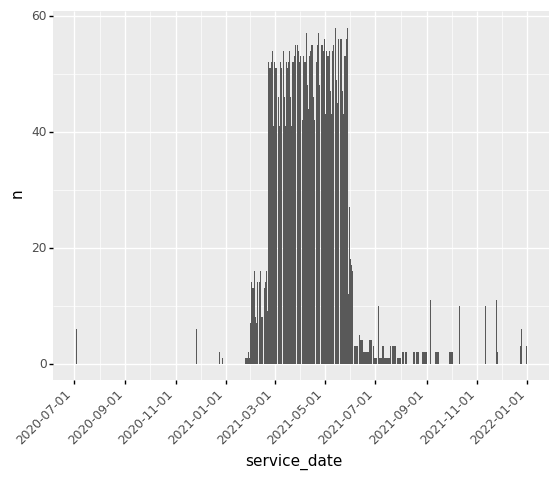

<ggplot: (299865457)>

In [12]:
join_keys = ["calitp_itp_id", "calitp_url_number", "service_id"]
join_cols = [_[k] for k in join_keys]

(
    exception_dates
    >> filter(_.service_date.between("2020-01-01", "2021-12-31"))
    >> count(_.service_date)
    >> collect()
    >> mutate(service_date = _.service_date.astype("datetime64[ns]"))
    >> ggplot(aes("service_date", "n")) + geom_col() + theme(axis_text_x = element_text(angle = 45, hjust = 1))
)

### Use 1: regular service

In [13]:
(
    exception_schedules
    >> distinct(_.calitp_itp_id, _.calitp_url_number, _.service_id)
    >> count(_.calitp_itp_id, _.calitp_url_number)
    >> head()
)

,calitp_itp_id,calitp_url_number,n
0,8,1,109
1,278,0,36
2,182,0,16
3,310,1,8
4,343,0,6


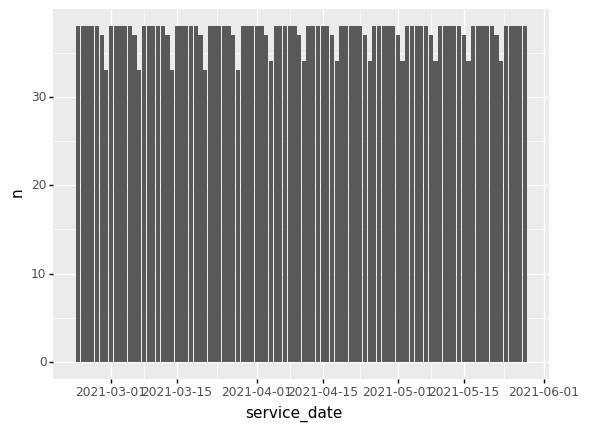

<ggplot: (-9223372036525444818)>

In [14]:
filter_itp8 = filter(_.calitp_itp_id == 8, _.calitp_url_number == 1)

(
    exception_schedules
    >> filter_itp8
    >> filter(_.service_date.dt.year.isin([2020, 2021]))
    >> collect()
    >> count(_.service_date)
    >> mutate(service_date = _.service_date.astype("datetime64[ns]"))
    >> ggplot(aes("service_date", "n")) + geom_col()
)

Note that they also have a `calendar.txt`, with 4 entries:

In [15]:
tbl.gtfs_schedule_calendar() >> filter_itp8 >> count() >> collect()

,n
0,4


However, it does not have any corresponding trips. In this case, it looks like they rely purely on their `calendar_dates.txt` file!

In [16]:
(
    tbl.gtfs_schedule_calendar()
    >> filter_itp8
    >> inner_join(_, tbl.gtfs_schedule_trips(), [*pk_str, "service_id"])
    >> count()
)

,n
0,0


### Use 2: rare schedules

In [17]:
(
    tbl.gtfs_schedule_trips()
    >> filter(
        _.calitp_itp_id == 177,
        _.calitp_url_number == 0,
        _.service_id == "c_17149_b_none_d_0",
    )
    >> left_join(
        _,
        tbl.gtfs_schedule_routes(),
        ["calitp_itp_id", "calitp_url_number", "route_id"],
    )
    >> select(_.route_long_name, _.route_url, _.route_type)
    >> head(1)
)

,route_long_name,route_url,route_type
0,The Link - Baldwin Hills Parklands,https://dpw.lacounty.gov/transit/TheLinkBaldwin.aspx,3
